In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sub_df = pd.read_json('2019_to_2020_submissions.txt', lines=True)

In [3]:
list(sub_df.columns)

['all_awardings',
 'allow_live_comments',
 'archived',
 'author',
 'author_created_utc',
 'author_flair_background_color',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_template_id',
 'author_flair_text',
 'author_flair_text_color',
 'author_flair_type',
 'author_fullname',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_gild',
 'can_mod_post',
 'category',
 'content_categories',
 'contest_mode',
 'created_utc',
 'discussion_type',
 'distinguished',
 'domain',
 'edited',
 'gilded',
 'gildings',
 'hidden',
 'id',
 'is_crosspostable',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media',
 'media_embed',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',

In [4]:
sub_df = sub_df[['title','score','num_comments','upvote_ratio',
                          'created_utc','category',
                          'media_metadata','is_video','media','is_self','media_embed',
                          'total_awards_received']]

sub_df['created_utc'] = pd.to_datetime(sub_df['created_utc'],unit='s')

In [5]:
sub_df.head(5)

,title,score,num_comments,upvote_ratio,created_utc,category,media_metadata,is_video,media,is_self,media_embed,total_awards_received
0,The 2019 NBA Offseason is officially over,401,48,NaN,2019-10-01 00:13:55,NaN,NaN,False,None,True,{},0
1,[Highlight] Harden unveils his new one-legged ...,4087,636,NaN,2019-10-01 00:20:20,NaN,NaN,False,{'oembed': {'description': 'Check out this vid...,False,"{'content': '&lt;iframe class=""embedly-embed"" ...",3
2,NBATV: You need to stop squeezing the picture ...,582,20,NaN,2019-10-01 01:07:46,NaN,NaN,False,None,True,{},0
3,"James Harden has 10 points, 11 rebounds, and 1...",969,69,NaN,2019-10-01 01:13:18,NaN,NaN,False,None,True,{},0
4,"[Highlight] Harden putting on a show, Westbroo...",415,87,NaN,2019-10-01 01:24:20,NaN,NaN,False,{'oembed': {'description': 'Check out this vid...,False,"{'content': '&lt;iframe class=""embedly-embed"" ...",0


Let's quickly do some EDA to see how the dataset looks like. There are several immediate questions I have about the distribution of scores, and how those vary with other variables like comments (are more popular posts likely to be more commented on).

I'm also curious about the date (when does subreddit activity peak? Does this relate to NBA events like the playoffs, where more is at stake?)

# Post score distribution

*Preamble about upvotes*<br />
Any reddit reader with an account is given the ability to give an arbitrary post or comment an "upvote". This is analagous to a "like" in many other social media platforms including Youtube and Facebook. Posts and comments with more upvotes will become more visible to a new reader if they were to visit the relevant page hosting the post/comment.

Let's first take a look at the post score distribution. I expect this distribution to have an **exponential decaying shape**, because I would expect
that when a post first gains traction (i.e. score increases), the probability of getting an upvote from an arbitrary reader is proportional to the post's visibility on the front page. <br />

This means as long as a post is visible, it will be upvoted at a random, arbitrary rate, which can be modelled by a **Poissonian point process** (upvotes occur continuously and independently with an average rate). In other words, there must be a "survival decay rate" of posts, where the probability of a post surviving on the front page for longer (and therefore gaining more upvotes) exponentially decays with time. This should be reflected in the post score distribution, where the number of posts (representing probability) and number of upvotes (corresponding to survival time) can be modelled by an **exponential distribution**.


<AxesSubplot: >

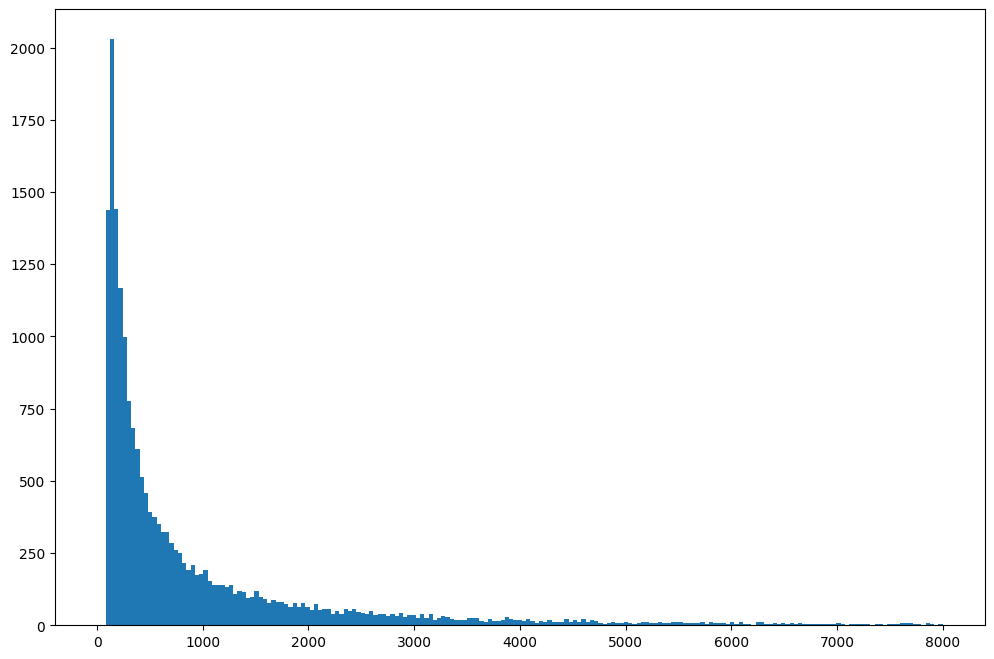

In [6]:
#Creating histogram bins for a score distribution histogram
bin_vec = np.linspace(0,8000,200)
bin_list = bin_vec.tolist()

sub_df['score'].hist(bins=bin_list,
                             grid=False,
                             figsize=(12,8))

# Date distribution

<AxesSubplot: title={'center': 'Post counts in 5 day intervals from 10/01/2019 to 06/01/2020'}, xlabel='Dates', ylabel='Counts'>

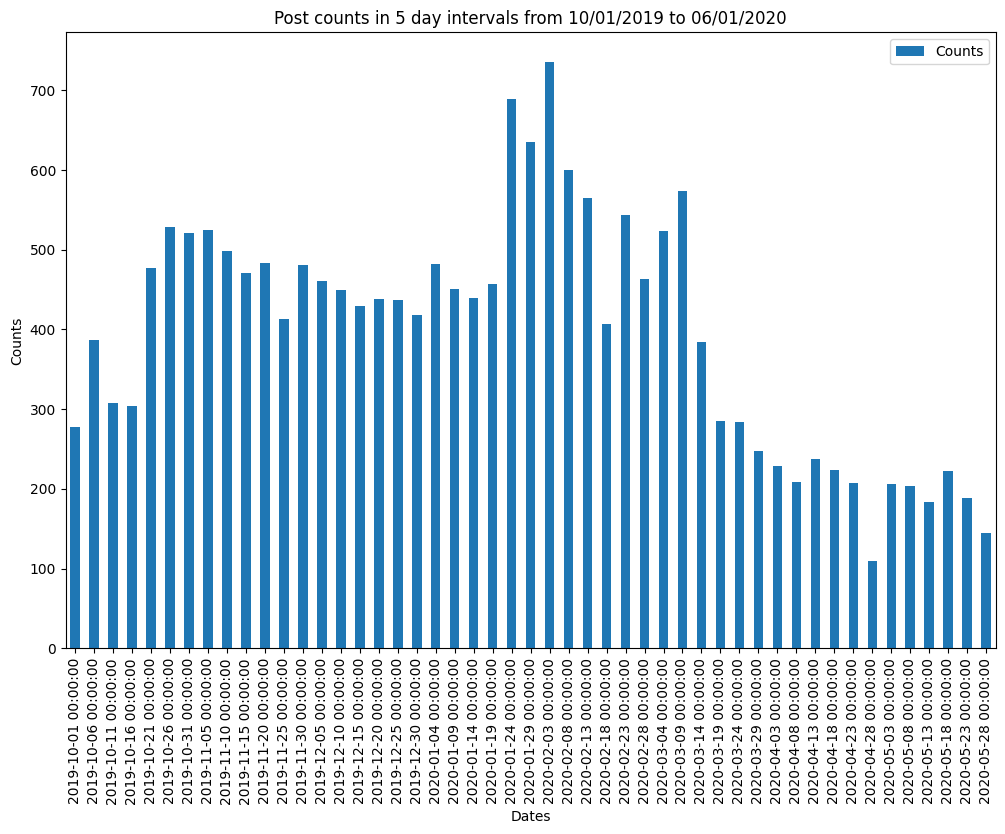

In [7]:
#Use pd.Grouper in order to group posts by dates with a date interval of 5 days.
#We get out a dataframe with the number of posts per 5 days from the start of the nba season to end of season

date_df = sub_df.groupby(pd.Grouper(key='created_utc',freq='5D')).size().to_frame()

#Rename columns so we have a clear x,y for plotting
date_df.rename(columns = {date_df.columns[0]: "Counts"}, inplace = True)
date_df.reset_index(inplace = True)

#Plot using df.plot
date_df.plot.bar(x='created_utc',y='Counts',
                 figsize = (12,8),
                 title = 'Post counts in 5 day intervals from 10/01/2019 to 06/01/2020',
                 xlabel= 'Dates',
                 ylabel= 'Counts')



Posts seem to have peaked in the beginning of February, and actually decrease to an annual low during the time period when playoffs occur. This could partially be because there are much fewer games during this time period, so there is alot less to discuss.

There is a key event called the **"NBA in-season trade deadline"**, before which players are able to be moved between teams. Many fans are excited with trade rumours as different teams explore a large variety of trade offers from other teams in the league. The deadline to move players was exactly on **February 6, 2020", which perfectly corresponds to a drop in the number of posts on the snapshot of 2020-02-08.


# Score/Comment correlation

We're also interested to see if more popular posts are more likely to get comments. This is a pretty obvious correlation, as the average reddit user is more likely to contribute to discussion that is more visible. Similarly, I would expect the comment distribution to also have an exponential distribution if the driving force behind commenting on a post and giving a post an upvote is similar (i.e. can be modelled by a Poissonian point process).

In [8]:
#Define quick labelling function
def plot_labelling(title,xlabel,ylabel):
    plt.title(label=title, fontdict = {'fontsize': 20})
    plt.xlabel(xlabel, fontdict = {'fontsize': 14})
    plt.ylabel(ylabel, fontdict = {'fontsize': 14})

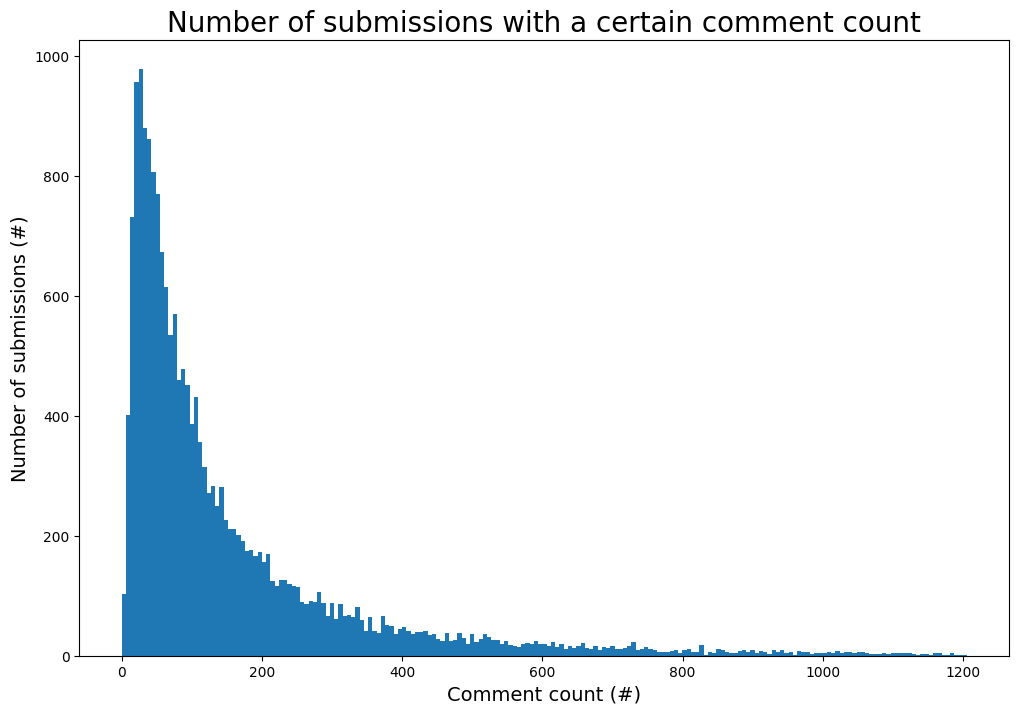

In [9]:
#Let's define a different set of bins for comments
#Let's define the bin maximum to be 1.5 standard deviations above the mean number of comments
bin_max= sub_df['num_comments'].mean() + sub_df['num_comments'].std() * 2

#Let's take the fiftieth percentile of the max comment length, which could be an anomaly
bin_vec = np.linspace(0,bin_max,200)
bin_list = bin_vec.tolist()

#Set up figures, axes
fig, axes = plt.subplots(nrows=1,ncols=1)

sub_df['num_comments'].hist(bins=bin_list,
                             grid=False,
                             figsize=(12,8),
                             ax=axes)

plot_labelling('Number of submissions with a certain comment count',
               'Comment count (#)',
               'Number of submissions (#)')

As expected, the change in number of submissions with comment count follows an exponential decay similar to post upvote score. Note that there is some sort of "rise" of this distribution at low comment counts which is uncharacteristic of an exponential distribution. This is not surprising as there are other factors that contribute to the number of comments a post will get aside from its "survival probability". These other effects could be modelled with another distribution which would be convolved with an exponential distribution.

**Think about this later**

Now, let's plot the score/comment distribution

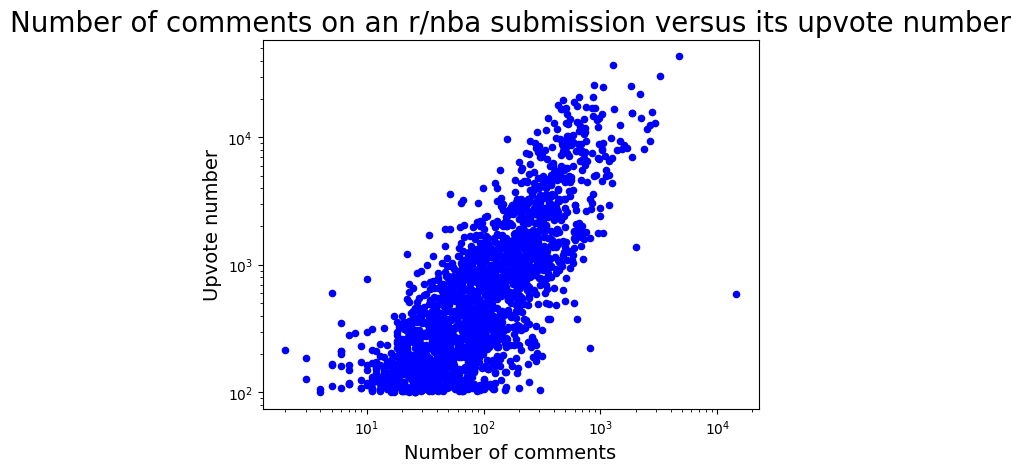

In [10]:
#Randomly subsample posts for plotting purposes (it's really noisy otherwise)
sub_df_subsample = sub_df.sample(n=2000)

sub_df_subsample.plot.scatter(x = 'num_comments', y = 'score',
                    s = 20, c = 'blue')
#Labelling
plot_labelling('Number of comments on an r/nba submission versus its upvote number',
               'Number of comments',
               'Upvote number')

#We need to log scale axes since most datapoints are clustered at low numbers
plt.xscale('log')
plt.yscale('log')




As expected, there is a positive correlation here. Note that there are a few standout posts where the number of comments far exceeds the number of upvotes. Let's try to see what kind of post titles show this kind of behavior

In [11]:
df_outliers = sub_df.loc[sub_df['num_comments'] > sub_df['score'] * 2]

#Filtering out random stuff
bad_title = ['Free Talk Thread']
mask = df_outliers['title'].isin(bad_title)
df_outliers = df_outliers[~mask]

In [12]:
df_outliers.head(6)

,title,score,num_comments,upvote_ratio,created_utc,category,media_metadata,is_video,media,is_self,media_embed,total_awards_received
163,Unprovoked Hate Thread: What NBA player do you...,127,344,NaN,2019-10-04 02:31:37,NaN,NaN,False,None,True,{},0
275,[Game Thread] The Los Angeles Lakers (0-0) @ T...,249,2035,NaN,2019-10-05 23:42:27,NaN,NaN,False,None,True,{},0
937,Who are three players or teams you dont believ...,129,290,NaN,2019-10-15 16:16:53,NaN,NaN,False,None,True,{},0
1000,What player or team gets the most excuses from...,121,359,NaN,2019-10-16 15:27:34,NaN,NaN,False,None,True,{},0
1229,Who will be the best PG in the league 5 years ...,112,265,NaN,2019-10-19 22:14:02,NaN,NaN,False,None,True,{},0
1238,What young player do you think will be out of ...,106,228,NaN,2019-10-20 02:52:50,NaN,NaN,False,None,True,{},0


We won't look into this too deeply, but there are certain types of posts that are often commented on much more than upvoted. For example, game threads often have many comments, but aren't upvoted very much since the comments are more reactionary to a live stream, rather than well thought out. In this case, the point of the thread is not to discuss the subject of the submission (i.e. the title), but more of an aggregation of comments associated with a game.

Now, let's get into the meat of the topic, which is to regress the upvote score based on title of a post. We could use some other metadata which is known a priori to creating a post (e.g. is this a discussion post, a media highlight, or even a crosslink to twitter for some recent news)

# Modifying a huggingface transformers model to perform upvote score regression on post metadata

Huggingface provides a large number of language models that can be run locally on most machines in order to perform a large variety of downstream tasks such as regression, classification, or even generative tasks as well. 

We'll be using one of the most popular models, "distilbert-base-uncased", and modifying it slightly in order to help us predict upvote scores based on post metadata, with a focus on the text of the title itself (as this is what we can control before we post). We will be excluding metadata that can only be determined after the post has become successful (e.g. number of comments, awards, etc.).

Let's import all necessary models/tools from the:
1. Transformers Library (all models/tokenizers for inference)
2. Dataset Library (data pipeline/batching for training)

In [32]:
#Use huggingface's transformers library to predict the score of a post based on its title
#We will use the DistilBERT model, which is a smaller version of BERT


from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel, AutoConfig

from datasets import Dataset, load_dataset, load_from_disk, load_metric

from sklearn.metrics import mean_squared_error

from torch import nn


Let's first transform our title text data into a format that is suitable for use by transformers (i.e. tokenization).

In [31]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#We can quickly check the max length of this tokenizer to make sure any of our post titles don't exceed it
print(f'Max tokenizer length is {tokenizer.model_max_length}')
print(f'Max post title length is {sub_df["title"].str.len().max()}')

Max tokenizer length is 512
Max post title length is 311


In [37]:
#Create a dataframe with just the title and score columns from sub_df
title_score_df = sub_df[['title','score']]
#Rename columns to match the format of the dataset
#This is the format that transformer library expects for training/evaluation
title_score_df.rename(columns = {'title': "text", 'score': "label"}, inplace = True)

#Convert sub_df into dataset format
#Preserve_index = False means that index of dataframe not kept
dataset = Dataset.from_pandas(title_score_df, preserve_index=False)
#Train test split dataset into 80% train, 20% test
dataset = dataset.train_test_split(test_size=0.2)

#dataset is in a dictionary format, making both train and test sets accessible



/var/folders/gs/2vxzz2sn2xb79y3v1l6mtp0r0000gn/T/ipykernel_21924/2605786963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_score_df.rename(columns = {'title': "text", 'score': "label"}, inplace = True)


In [38]:
#Load the tokenizer
#This converts the text into a sequence of text segments that the model was trained on (and can evaluate on)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#Tokenize the titles in dataset using map function
#Tokenizer pads the titles to the max length of 512 that the model has been trained to handle
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], padding="max_length",truncation=True), batched=True)



Map:   0%|          | 0/15548 [00:00<?, ? examples/s]

Map:   0%|          | 0/3887 [00:00<?, ? examples/s]

In [39]:
#View first example from the tokenized dataset
tokenized_example = tokenized_dataset['train']['input_ids'][0]
decoded_tokenized_example = tokenizer.decode(tokenized_example)

print(tokenized_example, decoded_tokenized_example)

[101, 1031, 6701, 1033, 6173, 6017, 5720, 2000, 2195, 1001, 6452, 2392, 2436, 12706, 1004, 23713, 1025, 6074, 2055, 4022, 3431, 2000, 1996, 17324, 2050, 1012, 2028, 1997, 1996, 2062, 23824, 16820, 2001, 2000, 3288, 2067, 1996, 1000, 16154, 9347, 1000, 2005, 2028, 2095, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
#Define loss function

def compute_rmse(eval):
    preds, labels = eval
    rmse = mean_squared_error(labels, preds, squared=False)
    return {"rmse": rmse}



In [41]:
#Grab input_ids and attention_mask from the tokenized dataset and put them into a dictionary
#This is the format that the model expects
tokenized_dataset['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



In [30]:
#Check model architecture
model_ref = "distilbert-base-uncased"
test_model = AutoModel.from_pretrained(model_ref, config = AutoConfig.from_pretrained(model_ref, output_attentions = True, output_hidden_states=True))
test_model.base_model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [43]:
tokenized_dataset['train'][0]['input_ids'].shape

torch.Size([512])

In [42]:
#Check model output on first example from training set
test_output = test_model(tokenized_dataset['train'][0]['input_ids'].unsqueeze(0), tokenized_dataset['train'][0]['attention_mask'].unsqueeze(0))
#Check dimensions of test_output
test_output[0].shape


TypeError: DistilBertModel.forward() got an unexpected keyword argument 'label'

In [24]:
#While we can use a higher level wrapped training loop and trainer class, we will write dissect the model architecture in order to show
#both understanding of a general deep learning model and training loop, and incorporation of additional features that may be useful for regression

#Define new nn.Module class incorporating the huggingface DISTILBERT model
#We will grab the raw embedding output of the model and feed it into an MLP

class DistilBertRegression(nn.Module):
    def __init__(self, model_ref):
        super(DistilBertRegression, self).__init__()
        self.model = AutoModel.from_pretrained(model_ref, config = AutoConfig.from_pretrained(model_ref, output_attentions = True, output_hidden_states=True))
        self.Dropout = nn.Dropout(0.2)
        self.Linear = nn.Linear(768, 1)

    def forward(self, input_ids = None, attention_mask = None, labels = None):
        #Raw embedding output of model
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        #Custom layers below
        #1. Apply dropout
        last_hidden = self.Dropout(outputs[0])
        

        

